In [1]:
# import the necessary packages
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os

In [2]:
shape_predictor= "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor)

In [3]:
image_files= glob.glob("images/*.png", )

In [26]:
def calc_landmarks_from_file(image_file,draw=True):
    #read the points file
    points_file= image_file.replace("png", "pts")
    points=np.genfromtxt(points_file,skip_header=3, skip_footer=1, delimiter=' ')
    bbox= np.max(points,axis=0)- np.min(points,axis=0)

    # read the image
    ori_image = cv2.imread(image_file)
    # resize the image to a width of 500 
    image = imutils.resize(ori_image, width=500)
    scale_factor=ori_image.shape[1]/500


    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # detect all faces in the grayscale image
    rects = detector(gray, 1)
    if len(rects) ==0: # i.e. if no candidates were found
        NaN=float("nan")
        return NaN,(NaN,NaN), ori_image.shape,scale_factor,len(rects)
    # loop over the face detections
    print (f"# BBs: {len(rects)}")
    best_normed_err=10
    
    for (i, rect) in enumerate(rects):
        
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)], then draw the face bounding box
        if True:
            (x, y, w, h) = face_utils.rect_to_bb(rect)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # show the face number
            cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            # loop over the (x, y)-coordinates for the facial landmarks
            # and draw them on the image
            for (x, y) in points:
                cv2.circle(image, (int(x/scale_factor),int(y/scale_factor)), 3, (0, 255, 0), -1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.show()
        shape= shape *scale_factor
        error = (shape- points)/bbox
        normed_err = np.sqrt(np.mean(np.linalg.norm(error, axis=1)**2))
        if normed_err <best_normed_err:
            best_normed_err = normed_err
            best_shape = shape

            
        
        
    if draw:
        for (x, y) in best_shape:
            cv2.circle(ori_image, (int(x),int(y)), int(2*scale_factor), (0, 0, 255), -1)
        for (x, y) in points:
            cv2.circle(ori_image, (int(x),int(y)), int(2*scale_factor), (0, 255, 0), -1)
        plt.imshow(cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB))
        plt.show()
    
    return best_normed_err,bbox, ori_image.shape,scale_factor, len(rects)




In [28]:
def getBoundingBox(image_file,draw=True):
    
    points_file= image_file.replace("png", "pts")
    #points=np.genfromtxt(points_file, delimiter=' ')
    points=np.genfromtxt(points_file,skip_header=3, skip_footer=1, delimiter=' ')
    
    ori_image = cv2.imread(image_file)
    # resize the image to a width of 500 
    image = imutils.resize(ori_image, width=500)
    scale_factor=ori_image.shape[1]/500
    '''
    #Get bounding box coordinates, width and height
    x, y = np.min(points, axis =0)
    w, h = np.max(points, axis =0)
    if (x >= 20):
        x -= 20
    if (y >= 20):
        y -= 20
    w = w-x+20
    h = h-y+20
    '''
    
    #Compute the BB
    x, y = np.min(points, axis =0)
    maxX, maxY = np.max(points, axis =0)
    
    w = maxX - x
    h = maxY - y
    
    #Leave more space around the landmarks
    if(x>=10):
        x-=10
        w+=20
    else:
        w+=10
    if(y>=10):
        y-=10
        h+=20
    else:
        y+=10
    
    if(w>h):
        if(y>=((w-h)/2)):
            y-=(w-h)/2
        h = w
    
    else:
        if(x>=((h-w)/2)):
            x-=(h-w)/2
        w = h
        
    if((int(y+h)-int(y)) < (int(x+w)-int(x))):
        h+=1
    elif((int(y+h)-int(y)) > (int(x+w)-int(x))):
        w+=1
    
    #Save cropped image around BB
    bb_file= image_file.replace("images", "bbimages")
    bb_file= bb_file.replace(".png", "BB.png")
    roi = ori_image[int(y):int(y+h), int(x):int(x+w)]
    #cv2.imwrite(bb_file, roi)
    
    #Modify landmark values and save them
    bb_p_file= bb_file.replace("png", "pts")
    points_bb = points - np.array([x,y])
    points_bb = np.around(points_bb, decimals=3)

    #np.savetxt(bb_p_file, points_bb, fmt='%1.3f', delimiter=' ')

    if(draw):
    
        cv2.rectangle(ori_image, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)
    
        for (x, y) in points:
            cv2.circle(ori_image, (int(x),int(y)), 3, (0, 255, 0), -1)

        plt.imshow(cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB))
        plt.show()

In [17]:
def NMError(pred, true, w, h):
    
    d = np.sqrt(w*h)
    NME = np.sum(np.sqrt(np.sum(np.square(true-pred), axis = 1))/d)/68
    
    return NME

def detectLandmarks(image_file,draw=True):
    #read the points file
    points_file= image_file.replace("png", "pts")
    points=np.genfromtxt(points_file, delimiter=' ')

    # read the image
    ori_image = cv2.imread(image_file)

    gray = cv2.cvtColor(ori_image, cv2.COLOR_BGR2GRAY)
    
    height, width, channels = ori_image.shape
    
    left = 0
    top = 0
    right = width
    bottom = height

    rect = dlib.rectangle(left, top, right, bottom)
    
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)
    
    if draw:
        # loop over the (x, y)-coordinates for the facial landmarks
        # and draw them on the image
        for (x, y) in shape:
            cv2.circle(ori_image, (x, y), 0, (0, 0, 255), -1)
        plt.imshow(cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB))
        plt.show()
    
    return NMError(shape, points, width, height)

In [13]:
def resizeTo224(image_file):
    
    points_file= image_file.replace("png", "pts")

    points=np.genfromtxt(points_file, delimiter=' ')
    ori_image = cv2.imread(image_file)
    height, width, channels = ori_image.shape
    # resize image
    dim = (224, 224)
    resized = cv2.resize(ori_image, dim, interpolation = cv2.INTER_AREA)
    
    #Save resized image
    bb_file= image_file.replace("bbimages", "bbimages224")
    bb_file= bb_file.replace("BB.png", ".png")
    cv2.imwrite(bb_file, resized)

    #Modify landmark values and save them
    bb_p_file= bb_file.replace("png", "pts")
    points_bb = points / (height/224)
    points_bb = np.around(points_bb, decimals=3)
    np.savetxt(bb_p_file, points_bb, fmt='%1.3f', delimiter=' ')

In [102]:
def resizeTo64(image_file):
    
    points_file= image_file.replace("png", "pts")

    points=np.genfromtxt(points_file, delimiter=' ')
    ori_image = cv2.imread(image_file)
    height, width, channels = ori_image.shape
    # resize image
    dim = (64, 64)
    resized = cv2.resize(ori_image, dim, interpolation = cv2.INTER_AREA)
    
    #Save resized image
    bb_file= image_file.replace("bbimages", "bbimages64")
    bb_file= bb_file.replace("BB.png", ".png")
    cv2.imwrite(bb_file, resized)

    #Modify landmark values and save them
    bb_p_file= bb_file.replace("png", "pts")
    points_bb = points / (height/64)
    points_bb = np.around(points_bb, decimals=3)
    np.savetxt(bb_p_file, points_bb, fmt='%1.3f', delimiter=' ')

In [14]:
image_files_to_resize=image_files

for image_file in image_files_to_resize:
    resizeTo224(image_file)


In [18]:
def printPoints(image_file, original = False):
    
    points_file= image_file.replace("png", "pts")

    if(original):
        points=np.genfromtxt(points_file,skip_header=3, skip_footer=1, delimiter=' ')
    else:
        points=np.genfromtxt(points_file, delimiter=' ')
    
    ori_image = cv2.imread(image_file)
    #z = np.zeros((64,64))
    for (x, y) in points:
        cv2.circle(ori_image, (int(x),int(y)), 2, (0, 255, 0), -1)
        #z+=generateHeatmap(int(y),int(x),False)
    
    #v = plt.imshow(z, cmap='hot', interpolation='nearest')
    #plt.show()
    plt.imshow(cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB))
    plt.show()

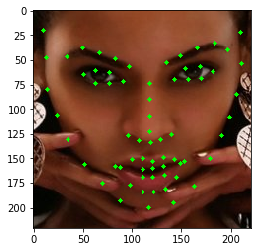

data/images\indoor_001.png


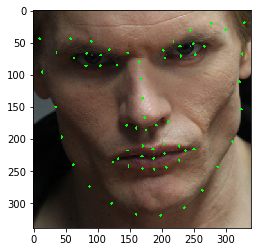

data/images\indoor_002.png


In [27]:
image_files_to_show=image_files[0:2]

for image_file in image_files_to_show:
    printPoints(image_file,False)
    print(image_file)

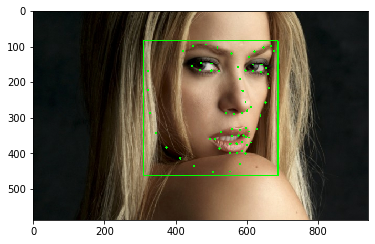

In [33]:
# this is where you select a subset of the files
image_files_to_explore=image_files[11:12]
# show  each picture?
draw =True

for image_file in image_files_to_explore:
    getBoundingBox(image_file,draw)

# BBs: 1


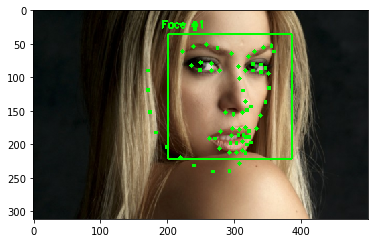

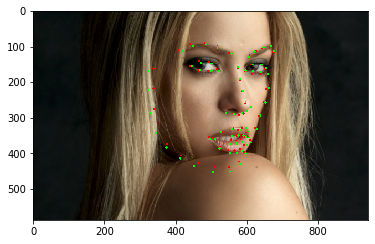

,FileName,Height,Width,BBox_W,BBox_H,Scale,Detected Faces,Normed_Err
0,images\indoor_012.png,587,940,352.216,357.639,1.88,1,0.024251


In [32]:
# This is w
# this is where you select a subset of the files
image_files_to_explore=image_files[11:12]
# show  each picture?
draw =True
df=pd.DataFrame(columns= ['FileName','Height','Width','BBox_W','BBox_H','Scale','Detected Faces','Normed_Err'])
for image_file in image_files_to_explore:
    normed_err, bbox, size,scale_factor,detected_faces = calc_landmarks_from_file(image_file, draw=draw)
    res={}
    res['FileName']=image_file
    res['Height']=size[0]
    res['Width']=size[1]    
    res['BBox_W']=bbox[0]
    res['BBox_H']=bbox[1]
    res['Scale']=scale_factor    
    res['Detected Faces']=detected_faces
    res['Normed_Err']=normed_err   
    
    df= df.append(res, ignore_index=True)
df

In [18]:
# This is w
image_files_to_explore=image_files
df=pd.DataFrame(columns= ['FileName','NME'])
for image_file in image_files_to_explore:
    NME = detectLandmarks(image_file, draw=False)
    res={}
    res['FileName']=image_file
    res['NME']=NME  
    
    df= df.append(res, ignore_index=True)
df

,FileName,NME
0,bbimages64\indoor_001.png,0.046789
1,bbimages64\indoor_002.png,0.024902
2,bbimages64\indoor_003.png,0.021233
3,bbimages64\indoor_004.png,0.032742
4,bbimages64\indoor_005.png,0.023207
...,...,...
595,bbimages64\outdoor_296.png,0.033742
596,bbimages64\outdoor_297.png,0.144310
597,bbimages64\outdoor_298.png,0.038583
598,bbimages64\outdoor_299.png,0.033861


In [19]:
np.mean(df.iloc[:,1])

0.06460921495841838

In [20]:
df.to_excel("dlib_test_results.xlsx")    
df

,FileName,NME
0,bbimages64\indoor_001.png,0.046789
1,bbimages64\indoor_002.png,0.024902
2,bbimages64\indoor_003.png,0.021233
3,bbimages64\indoor_004.png,0.032742
4,bbimages64\indoor_005.png,0.023207
...,...,...
595,bbimages64\outdoor_296.png,0.033742
596,bbimages64\outdoor_297.png,0.144310
597,bbimages64\outdoor_298.png,0.038583
598,bbimages64\outdoor_299.png,0.033861


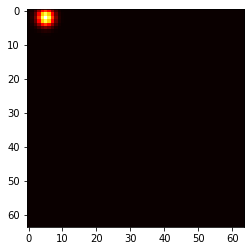

array([[1.92740121e-004, 1.16600979e-003, 4.72840285e-003, ...,
        1.16666317e-274, 1.78603595e-284, 1.83280860e-294],
       [3.51195399e-004, 2.12460835e-003, 8.61571172e-003, ...,
        2.12579889e-274, 3.25436969e-284, 3.33959500e-294],
       [4.28951028e-004, 2.59500250e-003, 1.05232541e-002, ...,
        2.59645663e-274, 3.97489611e-284, 4.07899054e-294],
       ...,
       [1.89055542e-306, 1.14371938e-305, 4.63801079e-305, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [8.71727499e-317, 5.27364401e-316, 2.13856810e-315, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000]])

In [193]:
def bivariateGaussianProb(x,y, meanX, meanY, scale):
    
    cov = np.eye(2)*2.5*(scale/64)
    x = np.array([x,y])
    #x = xT.reshape((2,1))
    mean = np.array([meanX,meanY])
    
    diff = x-mean
    
    const = 1/(np.sqrt(np.square(2*np.pi)*np.linalg.det(cov)))
    
    exp = np.exp((-1/2)*np.dot(np.dot(diff,np.linalg.inv(cov)),diff.reshape((2,1))))
    
    return const*exp
    
#Generate heatmap for keypoint (x,y)
def generateHeatmap(x,y, width, height, draw=False):
    
    z = np.zeros((width,height))
    for i in range(width):
        for j in range(height):
            z[i][j] = bivariateGaussianProb(i,j, x, y, max(width,height))
    
    if(draw):
        plt.imshow(z.T, cmap='hot', interpolation='nearest')
        plt.show()
        
    return z.T
    
generateHeatmap(5,2, 64, 64, True)

In [194]:
    def __init__(self, root_dir, width_in,height_in, width_out, height_out , max_size= None ):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        if type (max_size) is type (None):
            self.max_size = -1
        else:
            self.max_size = max_size
        self.input_path = root_dir
        self.width_in=width_in
        self.height_in=height_in
        self.width_out=width_out
        self.height_out=height_out
        self.frac = {"train": (0, 0.7), "valid": (0.7, 0.9), "test": (0.9, 1)}
        self.create_dataset()

    def __len__(self):
        return self.length


    def create_dataset(self):
        import pickle
        pickle_path = os.path.join(self.input_path, f"pickle_300W_{self.max_size}.p")
        if os.path.exists(pickle_path):
            print("loading from pickle file")
            data = pickle.load(open(pickle_path, "rb"))
            (self.x, self.y) = data
        else:
            subject_path = [os.path.join(self.input_path, 'Subject_0{}.mat'.format(i)) for i in range(1, 10)] + [
                os.path.join(self.input_path, 'Subject_10.mat')]
            m=len(subject_path)
            x = []
            y = []
            i=0
            data_indexes = [10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]
            while i < m and (len(x) < self.max_size or self.max_size==-1):
                path = subject_path[i]
                mat = scipy.io.loadmat(path)
                img_tensor = mat['images']
                fluid_tensor = mat['manualFluid1']
                img_array = np.transpose(img_tensor, (2, 0, 1)) / 255
                img_array = resize(img_array, (img_array.shape[0], self.width_in, self.height_in))
                fluid_array = np.transpose(fluid_tensor, (2, 0, 1))
                fluid_array = thresh(fluid_array)
                fluid_array = resize(fluid_array, (fluid_array.shape[0], self.width_out, self.height_out))
                x += [np.expand_dims(img_array[idx], 0) for idx in data_indexes]
                y += [np.expand_dims(fluid_array[idx], 0) for idx in data_indexes]
                i+=1
            self.x= np.array(x)
            self.y= np.array(y)
            data =(self.x, self.y)
            # pickle.dump(data, open(pickle_path, "wb"))
        self.length=len(self.x)

In [195]:
def resizeInput(image_file, landmarks, width, height):

    ori_image = cv2.imread(image_file)
    height_im, width_im, channels = ori_image.shape
    # resize image
    dim = (width, height)
    resized = cv2.resize(ori_image, dim, interpolation = cv2.INTER_AREA)

    #Modify landmark values
    
    landmarks = landmarks.astype('float').reshape((int(landmarks.shape[0]/2),2))
    ratio = np.array([(width_im/width),(height_im/height)])
    landmarks = landmarks / ratio
    landmarks = np.around(landmarks, decimals=3)
    
    return resized, landmarks

In [225]:
def create_dataset(root_dir, width_in,height_in, width_out, height_out , num_landmarks, max_size= None):
    input_path = root_dir
    if type (max_size) is type (None):
        max_size = -1

    import pickle
    pickle_path = os.path.join(input_path, f"pickle_300W_{max_size}.p")
    if os.path.exists(pickle_path):
        print("loading from pickle file")
        data = pickle.load(open(pickle_path, "rb"))
        (self.x, self.y) = data
    else:
        path = os.path.join(input_path,"300W.csv")
        dataset = pd.read_csv(path)

        image_paths = dataset.iloc[:,0].to_numpy()
        landmarks = dataset.iloc[:,1:].to_numpy()
        
        for i in range(len(image_paths)):
            image_paths[i] = os.path.join(input_path,"images/" + image_paths[i])
        
        x = []
        y = []
        
        for i, image_path in enumerate(image_paths):
            if(max_size != -1 and len(x)>=max_size):
                break
            #Resize the image to the input size
            resized, points = resizeInput(image_path, landmarks[i], width_in, height_in)
            x.append(resized)
            
            #Scale the landmark coordinates to the output size
            ratio = np.array([(width_in/width_out),(height_in/height_out)])
            points = np.around(points / ratio, decimals=3)
            
            #Get the heatmap for each landmark
            u = np.zeros((width_out,height_out,num_landmarks))
            for j, (x_p,y_p) in enumerate(points[:num_landmarks]):
                u[:,:,j] = generateHeatmap(x_p,y_p, width_out, height_out)
                
            y.append(u)
            
        x = np.array(x)
        y = np.array(y)
        
        for i, im in enumerate(x):
            plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
            plt.show()
            plt.imshow(y[i,:,:,0], cmap='hot', interpolation='nearest')
            plt.show()
            plt.imshow(y[i,:,:,1], cmap='hot', interpolation='nearest')
            plt.show()
        print("Y SHAPE {}".format(y.shape))
        

In [226]:
def printPointsCSV(ori_image, points):
    
    for (x, y) in points:
        cv2.circle(ori_image, (int(x),int(y)), 2, (0, 255, 0), -1)

    plt.imshow(cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB))
    plt.show()

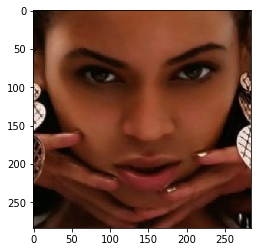

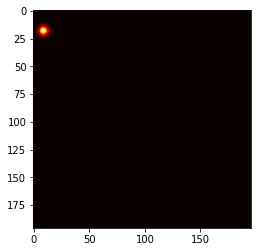

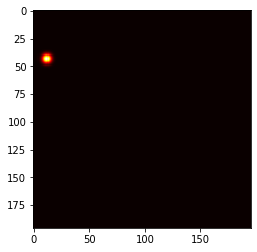

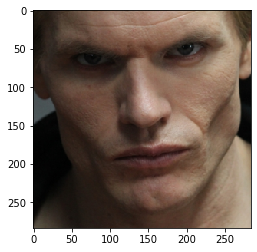

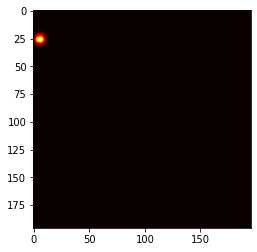

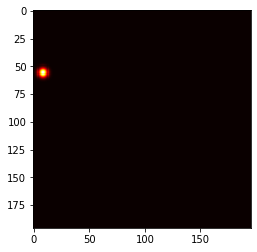

Y SHAPE (2, 196, 196, 2)


In [227]:
create_dataset("data/", 284, 284, 196, 196, 2, max_size= 2)

In [8]:
ori_image = cv2.imread("300Wdata/images/indoor_001.png")
print(ori_image.shape)

(224, 224, 3)


In [12]:
image_files= glob.glob("bbimages/*.png", )
for image_file in image_files:
    resizeInput(image_file, 284, 284)

In [24]:
def renameFile(image_file):
    
    points_file= image_file.replace("png", "pts")

    points=np.genfromtxt(points_file, delimiter=' ')
    ori_image = cv2.imread(image_file)
    
    #Save resized image
    bb_file= image_file.replace("bbimages", "data/images")
    bb_file= bb_file.replace("BB.png", ".png")
    cv2.imwrite(bb_file, ori_image)

    #Modify landmark values and save them
    bb_p_file= bb_file.replace("png", "pts")
    np.savetxt(bb_p_file, points, fmt='%1.3f', delimiter=' ')

In [25]:
image_files= glob.glob("bbimages/*.png", )
for image_file in image_files:
    renameFile(image_file)

In [215]:
def datasetToCSV(imagesPath):
    import posixpath
    path =posixpath.join(imagesPath, "*.png")
    images= np.array(glob.glob(path, ))
    for i, image in enumerate(images):
        images[i] = images[i].replace("\\", "/")

    landmarks = np.array([])
    for i, image_file in enumerate(images):
        points_file= image_file.replace("png", "pts")

        points=np.genfromtxt(points_file, delimiter=' ')

        points = points.flatten()
        if(i == 0):
            landmarks = np.hstack((landmarks,points))
        else:
            landmarks = np.vstack((landmarks,points))
            
    
    land_cols = []
    for i in range(136):
        land_cols.append("Land{}".format(i))
        
        
    for i, image in enumerate(images):
        images[i] = images[i].split('/')[-1]
        
    path_df = pd.DataFrame(images, columns = ["Path"])
    land_df = pd.DataFrame(landmarks, columns = land_cols)
    
    df = pd.concat([path_df, land_df], axis=1)
    
    df.to_csv('data/helen/helen.csv', index=False)
    
datasetToCSV("data/helen/non_mirror_images/")

In [65]:
f = np.array([[2,3],[4,5]])
u = np.array([1,2])
f/u

array([[2. , 1.5],
       [4. , 2.5]])

In [7]:
#HELEN DATASET
image_files= glob.glob("data/helen/ori_images/*.jpg", )

count = 0
for image_file in image_files:
    if(image_file.split("_")[-1] != "mirror.jpg"):
        ori_image = cv2.imread(image_file)
        points_file= image_file.replace("jpg", "pts")
        points=np.genfromtxt(points_file,skip_header=3, skip_footer=1, delimiter=' ')
        new_pt= points_file.replace("ori_images", "non_mirror_images")

        np.savetxt(new_pt, points, delimiter=' ')
        #Save cropped image around BB
        new_img= image_file.replace("ori_images", "non_mirror_images")
        cv2.imwrite(new_img, ori_image)
        count+=1

print(count)

2330


In [9]:
def datasetToCSV(imagesPath):
    import posixpath
    path =posixpath.join(imagesPath, "*.jpg")
    images= np.array(glob.glob(path, ))
    for i, image in enumerate(images):
        images[i] = images[i].replace("\\", "/")

    landmarks = np.array([])
    for i, image_file in enumerate(images):
        points_file= image_file.replace("jpg", "pts")

        points=np.genfromtxt(points_file, delimiter=' ')

        points = points.flatten()
        if(i == 0):
            landmarks = np.hstack((landmarks,points))
        else:
            landmarks = np.vstack((landmarks,points))
            
    
    land_cols = []
    for i in range(136):
        land_cols.append("Land{}".format(i))
        
        
    for i, image in enumerate(images):
        images[i] = images[i].split('/')[-1]
        
    path_df = pd.DataFrame(images, columns = ["Path"])
    land_df = pd.DataFrame(landmarks, columns = land_cols)
    
    df = pd.concat([path_df, land_df], axis=1)
    
    df.to_csv('data/helen/helen.csv', index=False)
    
datasetToCSV("data/helen/non_mirror_images/")

In [12]:
#Crop images around square bounding box
def getBoundingBoxes(csvPath):
    
    dataset = pd.read_csv(csvPath)
    
    #For each image in the dataset
    for i in range(dataset.shape[0]):

        #Get image
        imgPath = os.path.join("data/helen/non_mirror_images",dataset.iloc[i,0])
        ori_image = cv2.imread(imgPath)

        #Get points
        points = dataset.iloc[i,1:].to_numpy()
        points = points.astype('float').reshape((int(points.shape[0]/2),2))
        
        #Compute the BB
        x, y = np.min(points, axis =0)
        maxX, maxY = np.max(points, axis =0)

        w = maxX - x
        h = maxY - y

        #Leave more space around the landmarks
        if(x>=10):
            x-=10
            w+=20
        else:
            w+=10
        if(y>=10):
            y-=10
            h+=20
        else:
            y+=10

        #Make it square
        if(w>h):
            if(y>=((w-h)/2)):
                y-=(w-h)/2
            h = w

        else:
            if(x>=((h-w)/2)):
                x-=(h-w)/2
            w = h

        if((int(y+h)-int(y)) < (int(x+w)-int(x))):
            h+=1
        elif((int(y+h)-int(y)) > (int(x+w)-int(x))):
            w+=1
    
    
    
        #Save cropped image around BB
        bb_file= os.path.join("data/helen/","images/"+dataset.iloc[i,0])

        roi = ori_image[int(y):int(y+h), int(x):int(x+w)]
        cv2.imwrite(bb_file, roi)

        #Modify landmark values and save them
        points = points - np.array([x,y])
        points = np.around(points, decimals=3)
        points = points.flatten()
        dataset.iloc[i,1:] = points
        
    dataset.to_csv("data/helen/images/helen.csv", index=False)

getBoundingBoxes("data/helen/helen.csv")

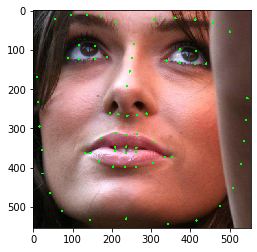

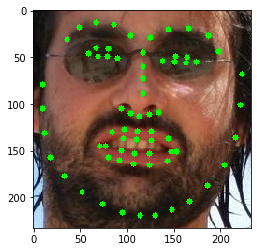

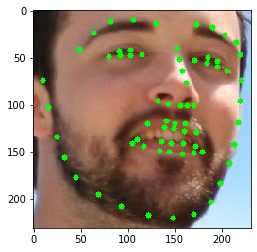

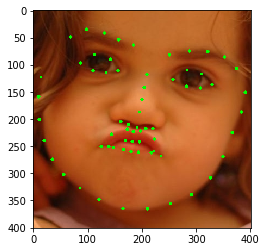

In [16]:
#Test is the cropping and rescaling of the points was correct
def printPoints(image_file, points):
    
    points = points.reshape((int(points.shape[0]/2),2))
    
    ori_image = cv2.imread(image_file)

    for (x, y) in points:
        cv2.circle(ori_image, (int(x),int(y)), 3, (0, 255, 0), -1)

    plt.imshow(cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB))
    plt.show()

dataset = pd.read_csv("data/helen/helen.csv")
for i in range(4):
    printPoints("data/helen/images/"+dataset.iloc[i,0], dataset.iloc[i,1:].to_numpy())